In [8]:
from OSCC_postprocessing.cine.functions_videos import *
from pathlib import Path
import json

# Video is in uint12 
video_bits = 12
brightness_levels = 2.0**video_bits



file = Path(r"G:\OSCC\LubeOil\BC20241003_HZ_Nozzle1\cine\T1\2.cine")
# Load the .cine file into a 3D numpy array (gray scale, shape: (Frame, Height, Width))
video = load_cine_video(file, frame_limit=100)

# Normalize the grayscale video to [0, 1] brightness range
video = video / brightness_levels

json_file = Path(r"G:\OSCC\LubeOil\BC20241003_HZ_Nozzle1\cine\T1\config.json")
with open(json_file, 'r', encoding='utf-8') as f:
    # Load metadata
    data = json.load(f)
    number_of_plumes = int(data['plumes'])
    # offset = float(data['offset']) # Not used in multi hole (Calculated later by FFT)
    centre = (float(data['centre_x']), float(data['centre_y']))
    ir_ = float(data["inner_radius"])   # inner radius (Injector radius)
    or_ = float(data["outer_radius"])   # outer radius (Quatz window radius)



print(f"The injector has {number_of_plumes} plumes.")
print(f"The nozzle is centred at ({centre[0]:.2f}, {centre[1]:.2f}) in image coordinates.")

data

Video Info - Width: 768, Height: 768, Frames: 100
The injector has 10 plumes.
The nozzle is centred at (392.50, 378.37) in image coordinates.


{'plumes': 10,
 'offset': 288.31,
 'centre_x': 392.498,
 'centre_y': 378.372,
 'inner_radius': 11.0,
 'outer_radius': 376.0}

In [9]:
from OSCC_postprocessing.playback.video_playback import *
play_video_cv2(video, intv=100)

In [12]:
# Importing libraries
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    # estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

import time
import warnings

import matplotlib.pyplot as plt
import numpy as np

from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.functions_bw import bw_boundaries_all_points
from OSCC_postprocessing.rotation.rotate_crop import generate_CropRect, generate_plume_mask
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    # estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

from OSCC_postprocessing.analysis.single_plume import (
    pre_processing_mie,
)

from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
    rotate_video_nozzle_at_0_half_numpy,
)
warnings.filterwarnings("ignore", category=RuntimeWarning)

global timing
timing = True

if timing:
    import time
import numpy as np
from OSCC_postprocessing.io.async_npz_saver import AsyncNPZSaver
from OSCC_postprocessing.io.async_avi_saver import *
from OSCC_postprocessing.filters.video_filters import *
from OSCC_postprocessing.playback.video_playback import *
from OSCC_postprocessing.analysis.single_plume import (
    USING_CUPY,
    cp,
    _min_max_scale,
    _rotate_align_video_cpu,
    binarize_single_plume_video,
    bw_boundaries_all_points_single_plume,
    bw_boundaries_xband_filter_single_plume,
    filter_schlieren,
    linear_regression_fixed_intercept,
    penetration_bw_to_index,
    pre_processing_mie,
    ransac_fixed_intercept,
    save_boundary_csv,
    to_numpy,
)
from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.binarized_metrics import processing_from_binarized_video
import pandas as pd

# Import rotation utility based on backend availability to avoid hard Cupy dependency
if USING_CUPY:
    from OSCC_postprocessing.rotation.rotate_with_alignment import (
        rotate_video_nozzle_at_0_half_cupy as rotate_video_nozzle_at_0_half_backend,
    )
else:
    from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
        rotate_video_nozzle_at_0_half_numpy as rotate_video_nozzle_at_0_half_backend,
    )

In [13]:
# Check the hardware used for image processing

use_gpu, triangle_backend, xp = resolve_backend(use_gpu="auto", triangle_backend="auto")

print("CUDA is used:", use_gpu)

print("xp represents numpy or cupy? :",xp)

CUDA is used: True
xp represents numpy or cupy? : <module 'cupy' from 'c:\\Users\\Jiang\\Documents\\Mie_Py\\Mie_Postprocessing_Py\\.venv311\\Lib\\site-packages\\cupy\\__init__.py'>


In [ ]:
# Selecting image rotation solver based on available hardware
if use_gpu:
    from OSCC_postprocessing.rotation.rotate_with_alignment import (
        rotate_video_nozzle_at_0_half_cupy as rotate_video_nozzle_at_0_half_backend,
    )
else:
    rotate_video_nozzle_at_0_half_backend = rotate_video_nozzle_at_0_half_numpy


In [14]:
from OSCC_postprocessing.filters.bilateral_filter import *
# upload to gpu or do nothing with cpu
video = xp.asarray(video)

# pakaged pre-processing calling, use this in real impelmentations
# foreground = pre_processing_mie(video, division=False)

# Explicitly coding for showing the whole process

# We do not divide by the first frame to fix lighting
# In the videos I process, they have some strong bright spots by reflections
# If didivde, they become some dark spots. 


'''
bilateral_filtered = bilateral_filter_video_volumetric_chunked_halo(
    video, (3, 5, 5), 3, 3
)
'''
# Bilateral filtering
if use_gpu:
    bilateral_filtered = bilateral_filter_video_cupy(video, 7, 3, 3)
else:
    bilateral_filtered = bilateral_filter_video_cpu(np.asarray(video), 7, 3, 3)



# Take the filtered first frame as background 
bkg = bilateral_filtered[0]
bkg[bkg == 0] = 1e-9
bkg[bkg == cp.nan] = 1e-9

# Foreground is the filtered video - filtered background
foreground = bilateral_filtered - bilateral_filtered[0][None, :, :]



In [15]:
# Visualize the filtering results
# play_video_cv2(video.get())
play_videos_side_by_side((video.get(), bilateral_filtered.get(), foreground.get()), intv=100) # type: ignore


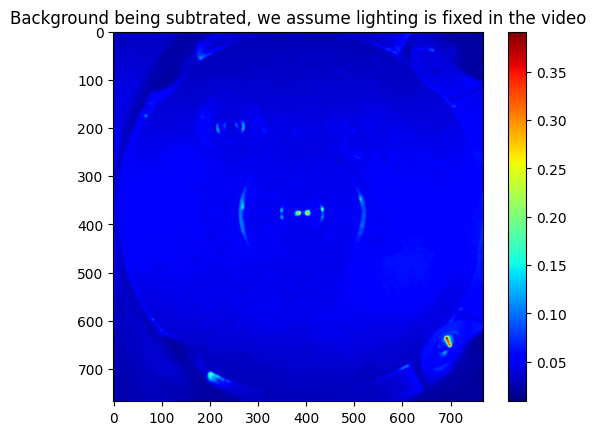

In [16]:
import matplotlib.pyplot as plt
plt.title("Background being subtrated, we assume lighting is fixed in the video")
plt.imshow(bkg.get(), cmap="jet")
plt.colorbar()

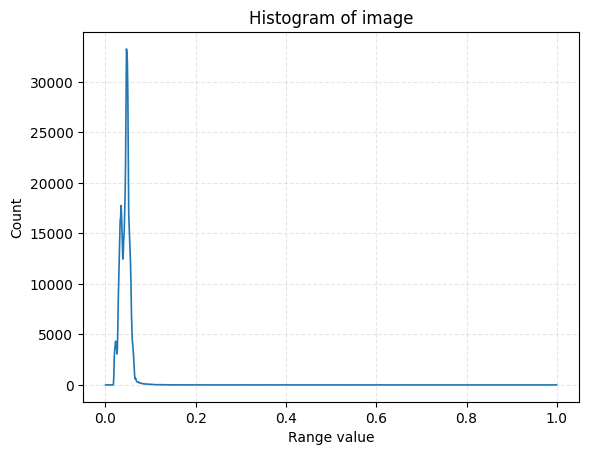

In [17]:
# Histogram of the background image
imhist(bkg.get())

In [18]:
from OSCC_postprocessing.analysis.multihole_utils import *
from OSCC_postprocessing.binary_ops.functions_bw import *
from OSCC_postprocessing.filters.video_filters import median_filter_video_auto, sobel_5x5_kernels, filter_video_fft
from OSCC_postprocessing.filters.svd_background_removal import godec_like
from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.filters.bilateral_filter import (
    bilateral_filter_video_cpu,
    bilateral_filter_video_cupy,
    bilateral_filter_video_volumetric_chunked_halo,
)
from OSCC_postprocessing.io.async_avi_saver import AsyncAVISaver
import numpy as np
import scipy.ndimage as ndi
from scipy.ndimage import binary_fill_holes
import os
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from OSCC_postprocessing.binary_ops.functions_bw import _triangle_threshold_from_hist, _boundary_points_one_frame
from OSCC_postprocessing.analysis.multihole_utils import triangle_binarize_gpu as _triangle_binarize_gpu




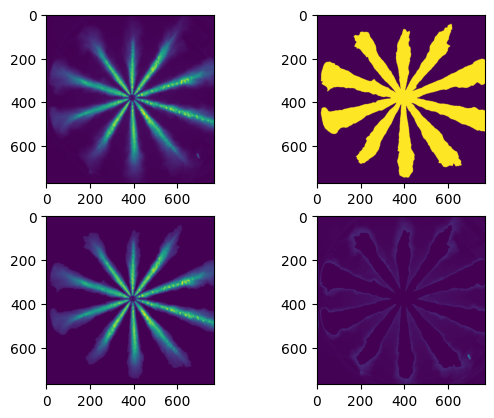

In [19]:
px_range_map = cp.max(foreground, axis=0) - cp.min(foreground, axis=0)


mask, _ = triangle_binarize_from_float(to_numpy(px_range_map))
mask = keep_largest_component(mask)
mask = binary_fill_holes(mask)
mask = cp.asarray(mask)


# Visualize max pixel range of each pixel in the video vs the mask made out of it
fig, ax = plt.subplots(2,2)

ax[0,0].imshow(px_range_map.get())
ax[0,1].imshow(mask.get())
ax[1,0].imshow((mask*px_range_map).get())
ax[1,1].imshow((px_range_map*(1- mask)).get())
# fig.set_title("Max pixel range of each pixel in the video vs the mask made out of it")


In [20]:
# visualize the masked video
foreground_masked = mask[None, :, :] * foreground

play_video_cv2(foreground_masked.get())

# play_video_cv2(10*xp.abs(foreground_masked-video).get())

(392.498, 378.372)

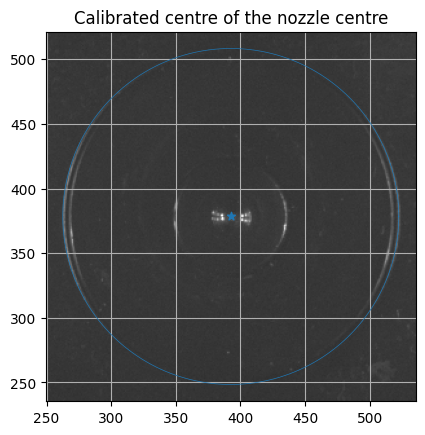

In [21]:
r = 130

# Displaying the clibration
plt.imshow(video[0].get()**0.5, cmap="gray")
plt.scatter(centre[0], centre[1], marker="*")

theta = np.linspace(0, 2*np.pi, 400)

x0, y0 = centre[0] , centre[1]

x = x0 + r * np.cos(theta)
y = y0 + r * np.sin(theta)

plt.plot(x, y, linewidth="0.5")
# plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
# plt.show()

plt.xlim([centre[0]-1.1*r, centre[0]+1.1*r])
plt.ylim([centre[1]-1.1*r, centre[1]+1.1*r])
plt.title("Calibrated centre of the nozzle centre")
centre


Text(0, 0.5, 'Frame number')

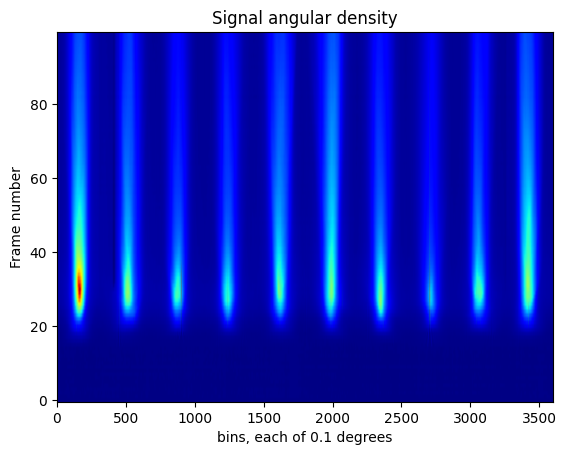

In [22]:
bins = 3600
start_time = time.time()
_, signal, _ = angle_signal_density_auto(foreground, centre[0], centre[1], N_bins=bins)

plt.imshow(signal, aspect="auto", origin="lower", cmap="jet")
plt.title("Signal angular density")
plt.xlabel(f"bins, each of {360.0/bins} degrees")
plt.ylabel("Frame number")

Estimated offset from FFT: 17.131 degrees


Text(0, 0.5, 'Total intensity in all frames (sum)')

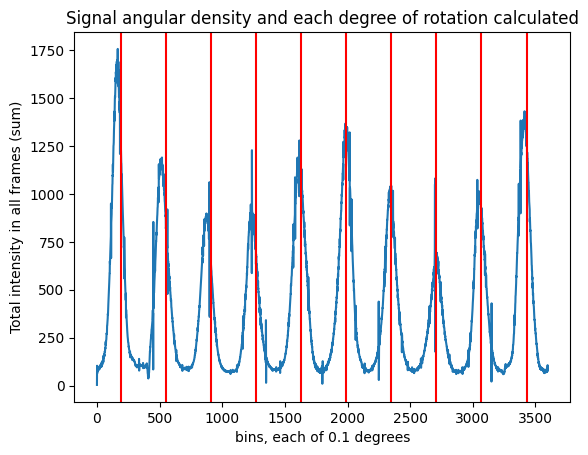

In [23]:
# Offset is calculated by the sum of angular signal in all frames
# (See the blue curve below)
# And setting the fundamental frequency to *number of plumes*,
# Find the best offset for this periodicity 

offset = estimate_offset_from_fft(signal, number_of_plumes)
if offset:
    print(f"Estimated offset from FFT: {offset:.3f} degrees")

angles = np.linspace(0, 360, number_of_plumes, endpoint=False) - offset

# foreground = xp.asarray(foreground, dtype=xp.float32)
summed_angular_density_all_frames = np.sum(signal, axis=0)
plt.plot(summed_angular_density_all_frames)

shift = np.sum(angles < 0) * 360.0/number_of_plumes

for idx, angle in enumerate(angles):
    plt.axvline((bins/360.0)*(angle+shift), color="r")

plt.title("Signal angular density and each degree of rotation calculated")
plt.xlabel(f"bins, each of {360.0/bins} degrees")
plt.ylabel("Total intensity in all frames (sum)")
    

In [24]:
# Rotation
 
# Frames, Height, Width
F, H, W = video.shape

# Allocate collector
segments = []

# Image rotation settings
INTERPOLATION = "nearest"
BORDER_MODE = "constant"

# Arbitrary rotated image strip shape
OUT_SHAPE = (H // 4, W//2)


for idx, angle in enumerate(angles):
    segment, _, _ = rotate_video_nozzle_at_0_half_backend(
            foreground,
            centre, # (nozzle_x, nozzle_y) # change to centre_x + cos(angle) * r, centre_y + sin(angle) * r
            # (centre[0] + np.cos(angle/180.0*np.pi) * ir_, centre[1] + np.sin(angle/180.0*np.pi) * ir_),
            angle,
            interpolation=INTERPOLATION,
            border_mode=BORDER_MODE,
            out_shape=OUT_SHAPE,
        )
    segments.append(segment)

segments = xp.stack(segments, axis=0)  # (Plume idx, Frame, H, W)

In [25]:
# Show a random segment
idx = np.random.random_integers(0, segments.shape[0]-1)
play_video_cv2(segments[idx].get())

C:\Users\Jiang\AppData\Local\Temp\ipykernel_24440\2590765415.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 9 + 1) instead
  idx = np.random.random_integers(0, segments.shape[0]-1)


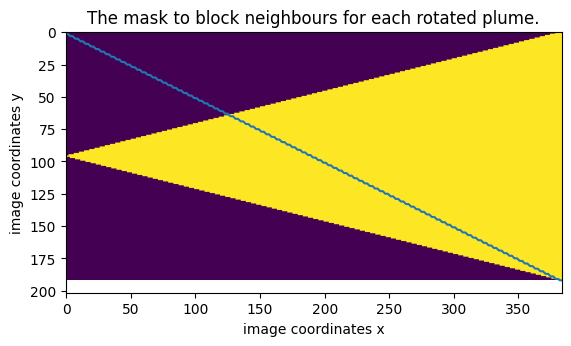

In [ ]:
plume_mask = generate_plume_mask(0, or_, segments.shape[3], segments.shape[2])
plt.imshow(plume_mask)
plt.title("The mask to block neighbours for each rotated plume.")
plt.xlabel("image coordinates x")
plt.ylabel("image coordinates y")

# plume_mask.shape
plume_mask_width = plume_mask.sum(axis=0)
# plt.plot(plume_mask_width)

In [27]:
# Array shape fitting and upload to the GPU
masks = cp.asarray(plume_mask[None, None, :, :])
# Apply the rotated masks
segments_masked = masks*segments




In [28]:

# Show a random segment
# idx = np.random.random_integers(0, segments_masked.shape[0]-1)
# play_video_cv2(segments_masked[idx].get())

# Show all rotated plumes
play_videos_side_by_side((cp.swapaxes(segments_masked, 2, 3)).get().tolist())

In [29]:
# Crop the rotated segments, from calibrated nozzle center to upper limit by the window

segments_corrected = segments_masked[:, :, :, int(ir_): int(or_)]
# Clip negative or ultra small values
segments_corrected[segments_corrected < 1e-4] = 0.0

play_videos_side_by_side((cp.swapaxes(segments_corrected, 2, 3)).get().tolist())

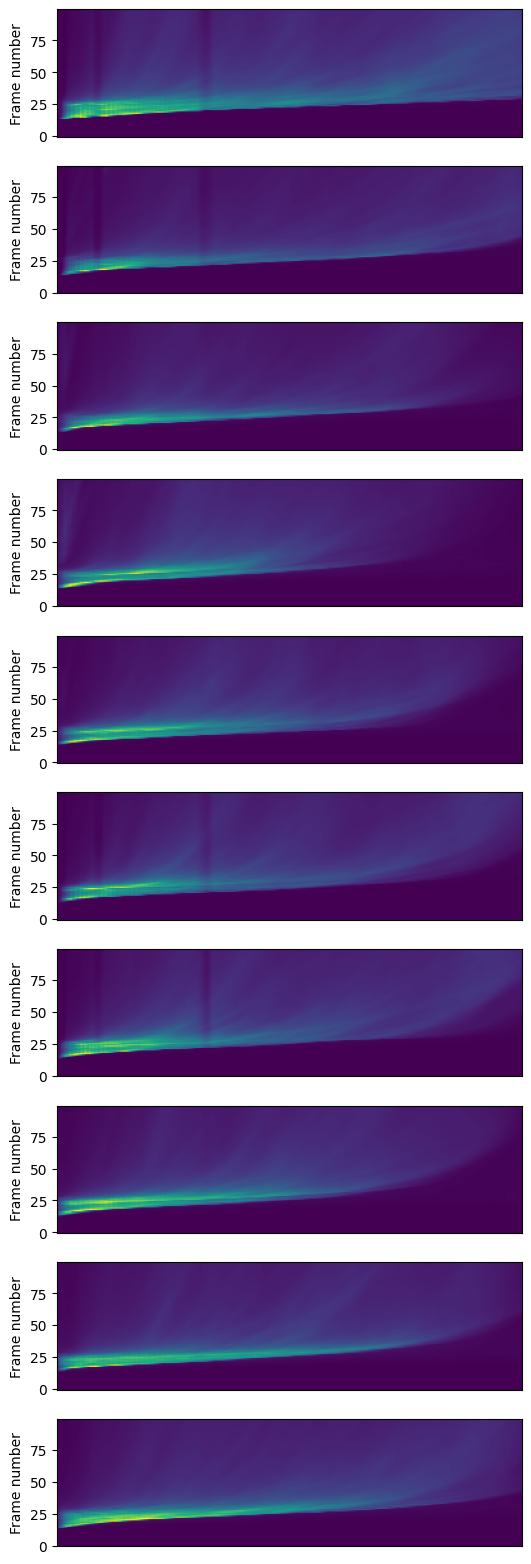

In [116]:
time_distance_intensity_maps = xp.sum(segments_corrected, axis=2)/segments_corrected.shape[2]/cp.asarray(plume_mask_width[None, None, int(ir_): int(or_)])


n = len(time_distance_intensity_maps)

fig, ax = plt.subplots(
    n, 1,
    figsize=(6, 2.0 * n),   # ← critical line
    sharex=True
)

for idx, td_map in enumerate(time_distance_intensity_maps):
    ax[idx].imshow(td_map.get(), origin="lower")
    ax[idx].set_ylabel("Frame number")

for a in ax[:-1]:
    a.set_xticks([])

# ax.set_title("Bruh")

Let's calculate penetration from the time-distance intensity maps.

In [117]:
frame_wise_sums = xp.sum(time_distance_intensity_maps, axis=-1)/time_distance_intensity_maps.shape[-1]


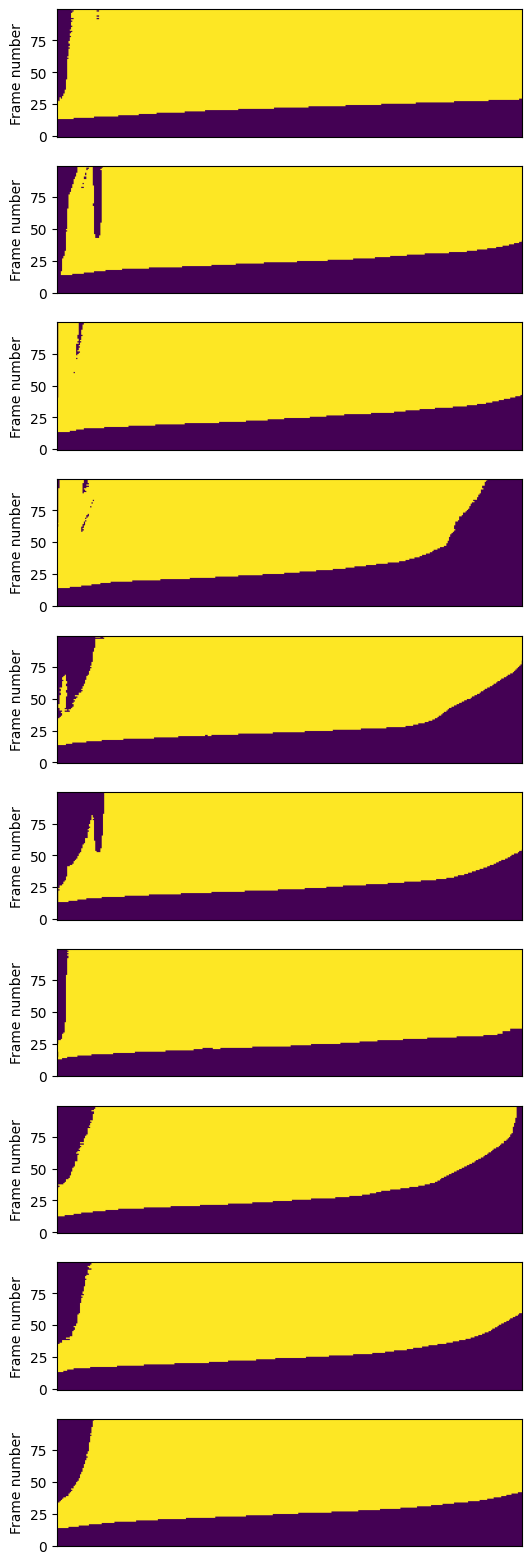

In [211]:
P, F, H, W = segments_corrected.shape
penetration_bw_td = cp.zeros((P, F, W))
penetration_td = cp.zeros((P, F))


for p in range(P):
    # for f in range(F-1):
    #     penetration_bw_td[p, f, :] =  triangle_binarize_gpu(time_distance_intensity_maps[p, f])
    penetration_bw_td[p] =  keep_largest_component_cuda(
            triangle_binarize_gpu(
                time_distance_intensity_maps[p])
                , connectivity=2)
    

n = len(time_distance_intensity_maps)

fig, ax = plt.subplots(
    n, 1,
    figsize=(6, 2.0 * n),   # ← critical line
    sharex=True
)

for idx, td_map in enumerate(penetration_bw_td):
    ax[idx].imshow(td_map.get(), origin="lower")
    ax[idx].set_ylabel("Frame number")


for a in ax[:-1]:
    a.set_xticks([])

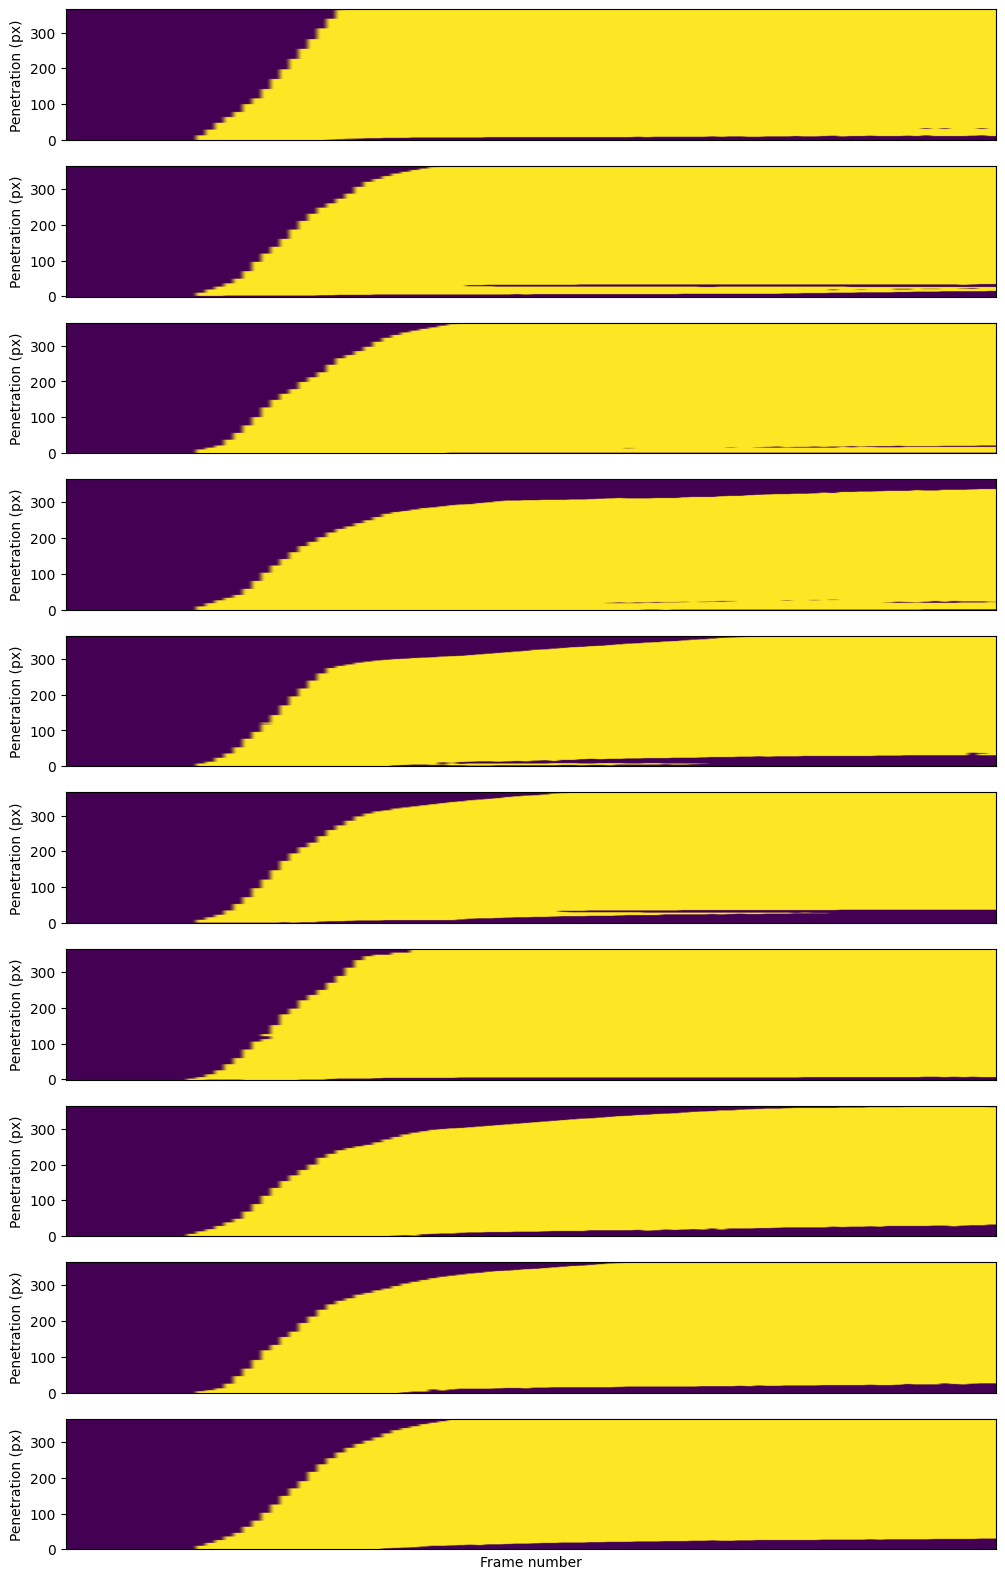

In [218]:
penetration_bw_td_T = cp.swapaxes(penetration_bw_td, 1,2)

n = len(time_distance_intensity_maps)

fig, ax = plt.subplots(
    n, 1,
    figsize=(12, 20),   # ← critical line
    sharex=True
)

for idx, td_map in enumerate(penetration_bw_td_T):
    ax[idx].imshow(td_map.get(), origin="lower", aspect="auto")
    ax[idx].set_ylabel("Penetration (px)")

ax[idx].set_xlabel("Frame number")


for a in ax[:-1]:
    a.set_xticks([])

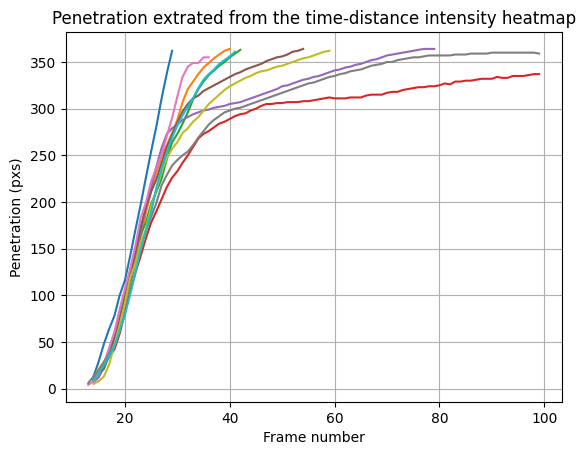

In [230]:
# penetration_bw_td_T has shape (Plume, Width, Frame)

penetration_td = penetration_bw_td_T.shape[1] - cp.argmax(penetration_bw_td_T[:, ::-1, :], axis=1)
penetration_td = penetration_td.astype(cp.float32)  # 或 cp.float64
penetration_td[penetration_td == penetration_bw_td_T.shape[1]] = cp.nan

plt.plot(penetration_td.T.get())
plt.title("Penetration extrated from the time-distance intensity heatmap")
plt.xlabel("Frame number")
plt.ylabel("Penetration (pxs)")
plt.grid()


In [87]:
brightness_peaks = xp.argmax(frame_wise_sums, axis=1)

peak_intensity_sums = xp.max(frame_wise_sums, axis=1)

Text(0, 0.5, 'Average pixel value')

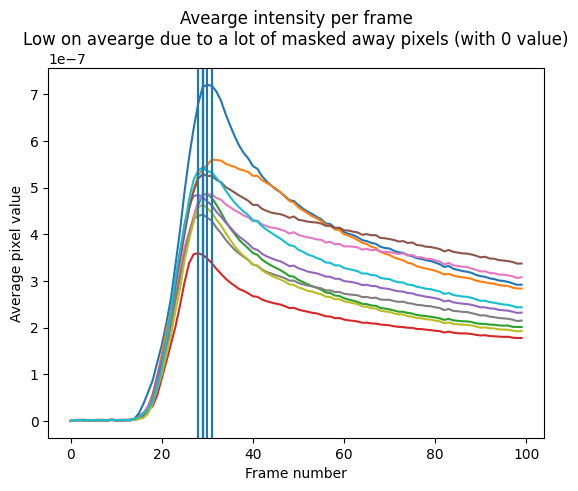

In [88]:
plt.plot(frame_wise_sums.T.get()/ segments_corrected.shape[2]/segments_corrected.shape[3])
for peak in brightness_peaks:
    plt.axvline(peak.get())

plt.title("Avearge intensity per frame\nLow on avearge due to a lot of masked away pixels (with 0 value)")
plt.xlabel("Frame number")
plt.ylabel("Average pixel value")

In [89]:
def _get_cupy():
    """Return the CuPy module if available, otherwise ``None``."""
    try:
        import cupy as cp  # type: ignore

        return cp
    except Exception:
        return None
    
    
def estimate_hydraulic_delay_segments(segments, avg_peak: int, use_gpu: bool, width=1.0/7, height = 0.1):
    """
    Hydraulic delay from a near-nozzle ROI derivative.
    Nozzle is assumed to be at position (H//2, 0)
    """
    if avg_peak  == 0:
        return np.zeros((segments.shape[0],), dtype=int)
    
    xp = _get_cupy() if use_gpu else np
    if use_gpu and xp is None:
        xp = np
        use_gpu = False

    rows = segments.shape[2]
    cols = segments.shape[3]
    
    H_low = round(rows * (1/width)//2 *width)
    H_high = round(rows * ((1/width)//2 +1 ) *width)
    W_right = round(cols *height)
    near_nozzle = xp.sum(
        xp.sum(segments[:, :avg_peak, H_low:H_high, :W_right], axis=3), axis=2
    )
    dE = xp.diff(near_nozzle[:, 0:avg_peak], axis=1)
    hydraulic_delay = (dE > 1).argmax(axis=1)
    return np.asarray(hydraulic_delay.get() if use_gpu else hydraulic_delay)

In [90]:
height = 1.0/5
width = 1.0/40

P, F, H, W = segments_corrected.shape
near_nozzle_intensity_sums = xp.sum(segments_corrected[:, :, int(H//2 - H*height//2):int(H//2 + H*height//2), :int(W*width)], axis=(2, 3))

Text(0, 0.5, 'intensity')

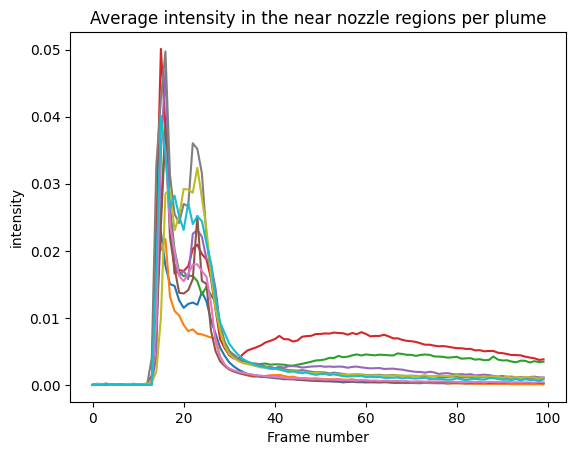

In [91]:
# play video patches
# play_videos_side_by_side((cp.swapaxes(segments_corrected[:, :, int(H//2 - H*height):int(H//2 + H*height), :int(W*width)], 2, 3)).get().tolist(), intv=60)

plt.plot(near_nozzle_intensity_sums.T.get() / (height* H * width*W))
plt.title("Average intensity in the near nozzle regions per plume")
plt.xlabel("Frame number")
plt.ylabel("intensity")

In [92]:
import numpy as np

def mad(x):
    med = np.median(x)
    return np.median(np.abs(x - med)) + 1e-12

def hysteresis_threshold(y, th_lo, th_hi):
    """
    滞回阈值：>th_hi 触发进入 high；<th_lo 退出 high。
    
    Hysteresis threshold:  
        When the value > th_hi, triggers high state;
        when the value < th_lo, exits high state
        """
    high = y > th_hi
    low  = y < th_lo

    mask = np.zeros_like(y, dtype=bool)
    state = False
    for i in range(len(y)):
        if not state:
            if high[i]:
                state = True
        else:
            if low[i]:
                state = False
        mask[i] = state
    return mask

def fill_short_false_runs(mask, max_len=3):
    """
    把 mask 中短的 False 段填成 True（填洞）。
    Filling short False pulses into True (hole-filling)
    """
    m = mask.copy()
    # 找 False runs
    diff = np.diff(m.astype(np.int8))
    starts = np.where(diff == -1)[0] + 1  # True->False 后 False 段开始
    ends   = np.where(diff ==  1)[0] + 1  # False->True 后 False 段结束
    if m[0] == False:
        starts = np.r_[0, starts]
    if m[-1] == False:
        ends = np.r_[ends, len(m)]
    for s, e in zip(starts, ends):
        if (e - s) <= max_len:
            m[s:e] = True
    return m

def remove_short_true_runs(mask, min_len=5):
    """把 mask 中短的 True 段删掉（去小岛）。"""
    """Filling up short True pulses with False (removing islands)"""
    m = mask.copy()
    diff = np.diff(m.astype(np.int8))
    starts = np.where(diff == 1)[0] + 1
    ends   = np.where(diff == -1)[0] + 1
    if m[0] == True:
        starts = np.r_[0, starts]
    if m[-1] == True:
        ends = np.r_[ends, len(m)]
    for s, e in zip(starts, ends):
        if (e - s) < min_len:
            m[s:e] = False
    return m

def longest_true_run(mask):
    """返回最长 True 连续段的 (start, end_exclusive)，若无 True 返回 None。"""
    """Retruan the longest True duration"""
    m = mask.astype(bool)
    if not m.any():
        return None
    diff = np.diff(m.astype(np.int8))
    starts = np.where(diff == 1)[0] + 1
    ends   = np.where(diff == -1)[0] + 1
    if m[0]:
        starts = np.r_[0, starts]
    if m[-1]:
        ends = np.r_[ends, len(m)]
    lengths = ends - starts
    k = np.argmax(lengths)
    return int(starts[k]), int(ends[k])

def detect_single_high_interval(y, x=None,
                                base_quantile=0.50,
                                scale_quantile=0.10,
                                k_hi=8.0, k_lo=4.0,
                                fill_hole_len=3,
                                min_island_len=5):
    """
    y: 1D 信号
    x: 可选真实坐标；不传则用索引
    阈值：th_hi = base + k_hi * sigma, th_lo = base + k_lo * sigma
    sigma 用 MAD 估计（鲁棒）

    y: 1D signal,
    x: Can accecpt real coordinates, 
    """
    y = np.asarray(y)
    if x is None:
        x = np.arange(len(y))
    else:
        x = np.asarray(x)

    # 1) 基线与尺度（鲁棒）
    base = np.quantile(y, base_quantile)
    sigma = 1.4826 * mad(y - base)  # MAD->std 等效（对高斯噪声）
    th_hi = base + k_hi * sigma
    th_lo = base + k_lo * sigma

    # 2) 滞回二值化
    mask = hysteresis_threshold(y, th_lo=th_lo, th_hi=th_hi)

    # 3) 清理：填洞 + 去小岛
    mask = fill_short_false_runs(mask, max_len=fill_hole_len)
    mask = remove_short_true_runs(mask, min_len=min_island_len)

    # 4) 只保留最长段
    run = longest_true_run(mask)
    if run is None:
        return None, mask, (th_lo, th_hi)

    s, e = run
    # 输出坐标：起点 x[s]，终点 x[e-1]（最后一个 True 的点）
    return (x[s], x[e-1], s, e-1), mask, (th_lo, th_hi)


In [93]:
import numpy as np
import cupy as cp

Lo_Hi = cp.zeros_like(near_nozzle_intensity_sums, dtype=cp.bool_)

num_cases, N = near_nozzle_intensity_sums.shape
hydraulic_delay = np.zeros(num_cases, dtype=np.float32)
nozzle_closing = np.zeros(num_cases, dtype=np.float32)

for idx in range(num_cases):
    y = near_nozzle_intensity_sums[idx].get()  # cupy -> numpy
    res, mask, _ = detect_single_high_interval(y)

    if res is None:
        hydraulic_delay[idx] = np.nan
        nozzle_closing[idx] = np.nan
        Lo_Hi[idx, :] = False
        continue

    (hd, nc, _, _) = res   # 这里 hd/nc 是 x_start/x_end（如果你 x=None）
    hydraulic_delay[idx] = hd
    nozzle_closing[idx] = nc

    Lo_Hi[idx, :] = cp.asarray(mask, dtype=cp.bool_)



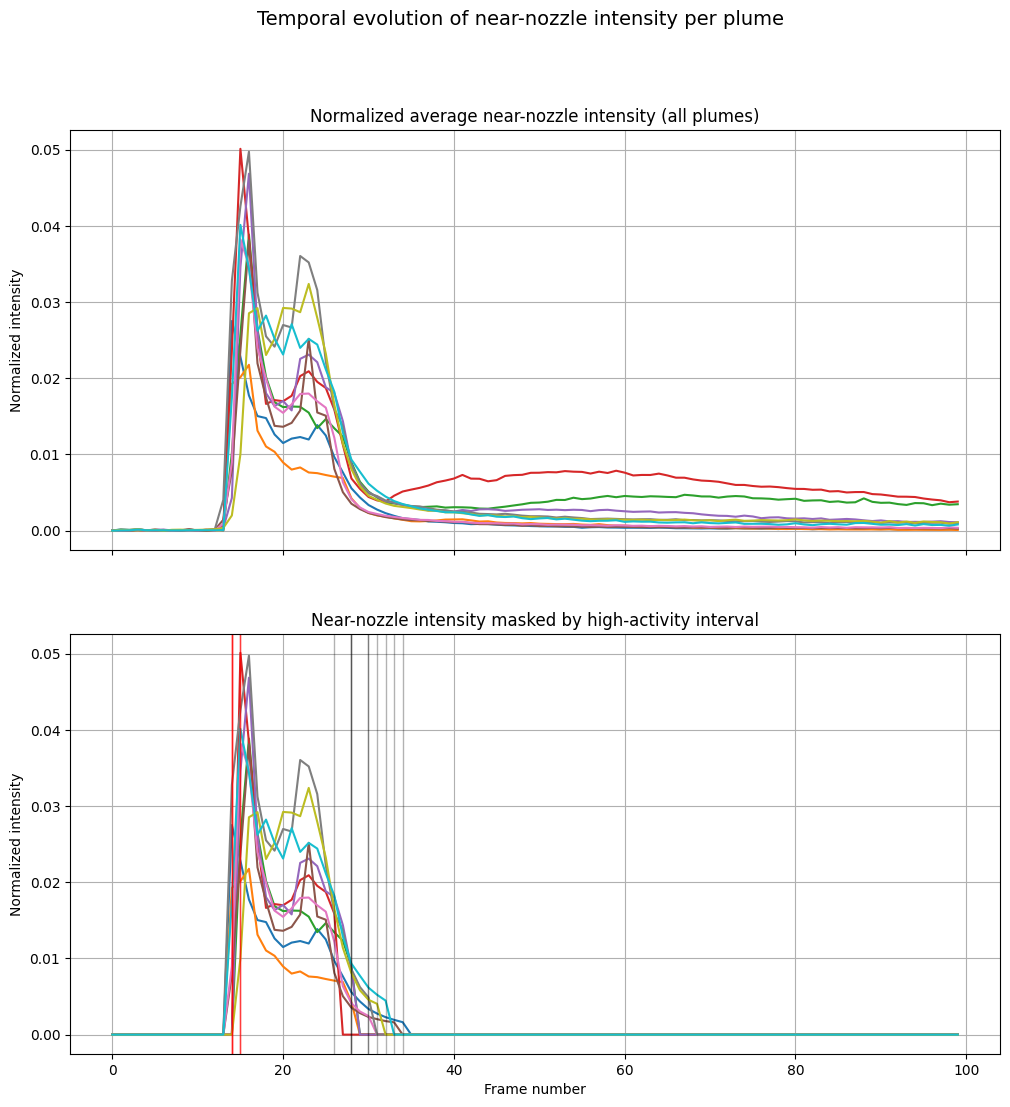

In [94]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

norm = (height * H * width * W)

# 上：原始（或平滑后）近喷嘴平均强度
ax[0].plot((near_nozzle_intensity_sums / norm).T.get())
ax[0].set_title("Normalized average near-nozzle intensity (all plumes)")
ax[0].set_ylabel("Normalized intensity")

# 下：仅保留 high 区间后的强度
ax[1].plot(((Lo_Hi * near_nozzle_intensity_sums) / norm).T.get())
ax[1].set_title("Near-nozzle intensity masked by high-activity interval")
ax[1].set_ylabel("Normalized intensity")
ax[1].set_xlabel("Frame number")

# 标注关键时间点
for i in range(num_cases):
    ax[1].axvline(nozzle_closing[i], color="k", alpha=0.3, linewidth=1)
    ax[1].axvline(hydraulic_delay[i], color="r", alpha=0.3, linewidth=1)

fig.suptitle("Temporal evolution of near-nozzle intensity per plume",
             fontsize=14)

# plt.tight_layout(rect=[0, 0, 1, 0.97])
ax[0].grid()
ax[1].grid()
plt.show()


In [95]:
# Play the videos in the nozzle opening durations and in the near-nozzle zone
play_videos_side_by_side((cp.swapaxes(segments_corrected[:, int(np.min(hydraulic_delay)):int(np.max(nozzle_closing)), int(H//2 - H*height//2):int(H//2 + H*height//2), :int(W*width)], 2, 3)).get().tolist(), intv=150)

In [96]:
def compute_cone_angle_from_angular_density(signal, offset, number_of_plumes, *, bins=3600, use_gpu=False):
    """Shared GPU/CPU cone-angle computation."""
    shift_bins = int(offset / 360 * bins)
    try:
        if use_gpu:
            cp = _get_cupy()
            if cp is None:
                raise RuntimeError
            from cupyx.scipy.ndimage import binary_closing as cp_binary_closing  # type: ignore

            sig_cp = cp.asarray(signal, dtype=cp.float32)
            bw_cp = triangle_binarize_gpu(sig_cp)
            bw_cp = cp.roll(bw_cp, -shift_bins, axis=1)
            struct_cp = cp.ones((1, 3), dtype=cp.bool_)
            bw_closed = cp_binary_closing(bw_cp, structure=struct_cp)

            cone_angle = np.zeros((number_of_plumes, bw_closed.shape[0]), dtype=np.float32)
            deg_per_bin = 360.0 / bins
            for p in range(number_of_plumes):
                start = int(round(p * bins / number_of_plumes))
                end = int(round((p + 1) * bins / number_of_plumes))
                s = bw_closed[:, start:end].sum(axis=1) * deg_per_bin
                cone_angle[p] = cp.asnumpy(s)
            return cone_angle
        raise RuntimeError
    except Exception:
        from scipy.ndimage import binary_closing

        bw_u8, _ = triangle_binarize_from_float(signal, blur=True)
        bw_shifted = np.roll(bw_u8 > 0, -shift_bins, axis=1)
        struct = np.ones((1, 3), dtype=bool)
        bw_closed = binary_closing(bw_shifted, structure=struct)

        cone_angle = np.zeros((number_of_plumes, bw_closed.shape[0]), dtype=np.float32)
        deg_per_bin = 360.0 / bins
        for p in range(number_of_plumes):
            start = int(round(p * bins / number_of_plumes))
            end = int(round((p + 1) * bins / number_of_plumes))
            cone_angle[p] = bw_closed[:, start:end].sum(axis=1) * deg_per_bin
        return cone_angle

Testing triangle binarization


In [294]:
import scipy.ndimage as ndi
from scipy.ndimage import binary_fill_holes
from OSCC_postprocessing.analysis.single_plume import _binary_fill_holes_gpu
from OSCC_postprocessing.binary_ops.functions_bw import keep_largest_component_nd_cuda

bw = cp.zeros_like(segments_corrected, dtype=bool)

for i in range(len(segments_corrected)):
    # Binarize the each video
    vid = _min_max_scale(segments_corrected[i])
    bw_vid = triangle_binarize_gpu(vid, ignore_zeros=True)
    # Fill binary holes, frame-wise per video
    bw_vid = _binary_fill_holes_gpu(bw_vid, mode="2D")
    # Keep the largest 3D blob volume in binarized 3D array (aka video)
    bw[i] = keep_largest_component_nd_cuda(bw_vid)



In [295]:
for idx in range(0, len(segments_corrected)):
    play_videos_side_by_side(
        (
            cp.swapaxes(segments_corrected, 2, 3)[idx].get(),
            cp.swapaxes(bw*segments_corrected, 2, 3)[idx].get(),
            cp.swapaxes((bw)*255.0, 2, 3)[idx].get()
        )
    )


In [296]:
# Processing boundaries
bw_col_sum = xp.sum(bw, axis=-2)
df_list = list()
boundary_list = list()

for p in range(P):
    df_bw, boundary = processing_from_binarized_video(bw[p].get(), bw_col_sum[p].get(), timing=True)
    df_list.append(df_bw)
    boundary_list.append(boundary)    

Binarization and boundary extraction completed in: 0.05 seconds
Cone angle calculations completed in: 0.05 seconds
Binarization and boundary extraction completed in: 0.04 seconds
Cone angle calculations completed in: 0.07 seconds
Binarization and boundary extraction completed in: 0.04 seconds
Cone angle calculations completed in: 0.15 seconds
Binarization and boundary extraction completed in: 0.04 seconds
Cone angle calculations completed in: 0.11 seconds
Binarization and boundary extraction completed in: 0.04 seconds
Cone angle calculations completed in: 0.09 seconds
Binarization and boundary extraction completed in: 0.04 seconds
Cone angle calculations completed in: 0.05 seconds
Binarization and boundary extraction completed in: 0.04 seconds
Cone angle calculations completed in: 0.08 seconds
Binarization and boundary extraction completed in: 0.04 seconds
Cone angle calculations completed in: 0.10 seconds
Binarization and boundary extraction completed in: 0.03 seconds
Cone angle calcu

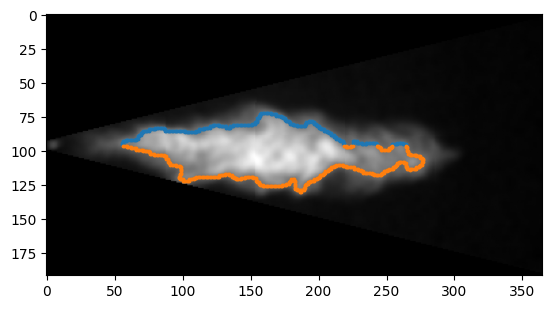

In [309]:
# len(df_list)
# df_list[0]
len(boundary_list[0])
idx = 3
frame = 40

plt.subplots()
for f in range(F):
    if f == frame:
        plt.imshow((segments_corrected)[idx, frame].get(), cmap="gray")
        if boundary_list[idx][f][0].shape[0] > 0 and boundary_list[idx][f][1].shape[0] > 0:
            up = boundary_list[idx][f][0]
            down = boundary_list[idx][f][1]
            
            plt.scatter(up[:,1], up[:,0], s=3)
            plt.scatter(down[:,1], down[:,0], s=3)
                        # print(boundary_list[idx][f])

In [331]:
# Centering the boundary coordinates to y=0
boundary_list_centered = []

for p in range(P):
    for f in range(F):
        up = boundary_list[idx][f][0]
        down = boundary_list[idx][f][1]

        up_y = up[:, 0]- H // 2;   up_x = up[:, 1] 
        down_y = down[:, 0]- H // 2; down_x = down[:, 1] 

        copied_up = np.zeros_like(up)
        copied_down = np.zeros_like(down)
        copied_up[:, 0] = up_y;   copied_up[:, 1] = up_x
        copied_down[:, 0] = down_y; copied_down[:, 1] = down_x
        
        boundary_list_centered.append((copied_up, copied_down))

len(boundary_list_centered): 1000
idx: 3
len(boundary_list_centered[idx]): 2


Text(0.5, 1.0, 'Scattered boundary points at slected frames in plume index 3')

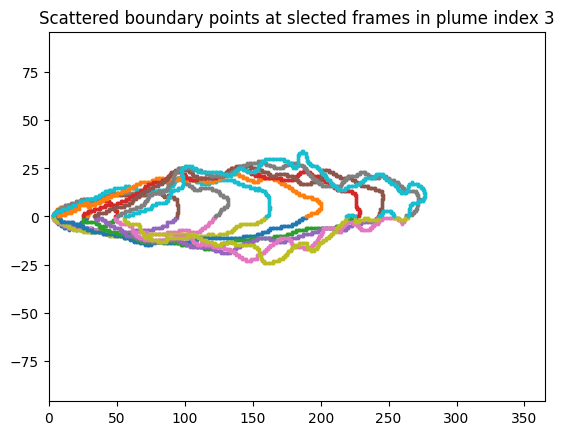

In [336]:
print("len(boundary_list_centered):", len(boundary_list_centered))
print("idx:", idx)
print("len(boundary_list_centered[idx]):", len(boundary_list_centered[idx]))

selected_frames = [17, 19, 21, 23, 25, 27, 30, 32, 36, 40]
for f in selected_frames:
    up = boundary_list_centered[f][0]
    down = boundary_list_centered[f][1]
    plt.scatter(up[:, 1], up[:, 0], s=3)
    plt.scatter(down[:, 1], down[:, 0], s=3)

plt.xlim([0, W])
plt.ylim([-H//2, H//2])

plt.title(f"Scattered boundary points at slected frames in plume index {idx}")



In [337]:
df_list[0].columns

Index(['Frame', 'Penetration_from_BW', 'Penetration_from_BW_Polar',
       'Cone_Angle_Average', 'Cone_Angle_RANSAC',
       'Cone_Angle_Linear_Regression', 'Area', 'Estimated_Volume',
       'Estimated_Volume_Upper_limit', 'Estimated_Volume_Lower_limit',
       'CA_Avg_Upper', 'CA_Avg_Lower', 'CA_Ransac_Upper', 'CA_Ransac_Lower',
       'CA_LG_Upper', 'CA_LG_Lower'],
      dtype='object')